**NLP Analysis - Reviews Data**

# Introduction

## Read in libraries, data, and set notebook preferences

**Read in libraries**

In [2]:
#Read in libraries
import pandas as pd
import swifter

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

**Read in data**

In [3]:
#Set path to data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python Projects\In Progress\Air BnB - SF\Data\03_Processed'

#Read in data
df = pd.read_csv(path + '/2020_0208_Reviews_Processed_NLP.csv',sep=',',
                 parse_dates=['date'])

**Set preferences for notebook**

In [73]:
#Ignore warnings
import warnings; warnings.simplefilter('ignore')

#Increase number of columns and rows displayed by Pandas
pd.set_option('display.max_colwidth',None)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows',100)

#Set style for plots
plt.style.use('Solarize_Light2')

## Preview data

In [5]:
#Preview data and shape
print('Reviews data shape:', df.shape)
display(df.head())

Reviews data shape: (425509, 6)


,comments,date,sentiment_compound,label,word_count,comments_pos_tag
0,"Hello Josh Thank you very much for everything. I found myself very comfortable in your home. Quiet, comfortable and very complete and very clean, which I value highly. Next time I'd come with my family. I hope it's possible.",2013-12-01,0.9534,positive,39,"[('hello', 'NN'), ('josh', 'NN'), ('thank', 'VBD'), ('much', 'JJ'), ('everything', 'NN'), ('comfortable', 'JJ'), ('home', 'NN'), ('quiet', 'RBR'), ('comfortable', 'JJ'), ('complete', 'JJ'), ('clean', 'JJ'), ('highly', 'RB'), ('next', 'JJ'), ('time', 'NN'), ('come', 'VBN'), ('possible', 'JJ')]"
1,"Stop and book it now. Rea (Website hidden by Airbnb) this later!!! If your a single person looking for a story book San Francisco experience, look no farther. Staying in Mikes place couldn't be any more wonderful. If your familiar with ""Tales of the City"" Mike is the Olympia Dukakis. The home is warm and inviting with all the nuances of an old Victorian. Mike is an amazing host . He can tell you how walk drive or public transit the city (don't bother with a car). Would love to keep the gem to myself but everyone deserves this unique place to lay your head. Make sure while you're there be introduced to William . Book IT you won't be disappointed .",2017-06-07,0.9334,positive,122,"[('stop', 'VB'), ('book', 'NN'), ('rea', 'JJ'), ('website', 'RB'), ('hidden', 'VBP'), ('later', 'RB'), ('person', 'NN'), ('looking', 'VBG'), ('book', 'NN'), ('san', 'JJ'), ('francisco', 'JJ'), ('experience', 'NN'), ('look', 'NN'), ('staying', 'VBG'), ('place', 'NN'), ('wonderful', 'NN'), ('familiar', 'JJ'), ('tales', 'NNS'), ('city', 'NN'), ('mike', 'NN'), ('olympia', 'VBP'), ('dukakis', 'NN'), ('home', 'NN'), ('inviting', 'NN'), ('nuances', 'NNS'), ('old', 'JJ'), ('victorian', 'JJ'), ('mike', 'NN'), ('amazing', 'VBG'), ('host', 'NN'), ('tell', 'NN'), ('walk', 'VBP'), ('drive', 'JJ'), ('transit', 'NN'), ('city', 'NN'), ('would', 'MD'), ('love', 'VB'), ('gem', 'NN'), ('everyone', 'NN'), ('deserves', 'VBZ'), ('unique', 'JJ'), ('place', 'NN'), ('head', 'NN'), ('make', 'VBP'), ('sure', 'JJ'), ('book', 'NN'), ('disappointed', 'VBD')]"
2,"So I moved to SF in late May from Michigan to intern at Genentech for the summer. I stayed at Anjan’s apartment for 7 days while I was looking for a more permanent housing situation. Anjan was extremely hospitable and welcoming throughout the week. He was also very knowledgeable about the area and always offered to help in any way that he could. The area (SOMA) is very safe and is very “walkable.” There are plenty of restaurants and stores nearby (there’s even a target a few blocks away), so you have everything you need within a couple blocks from the apartment. As for the bedroom, it was spacious and clean. The bathroom was nice and I had to myself for the entirety of my stay. I felt very comfortable living at Anjan’s for a week and I really enjoyed staying there. If you’re a respectful person and are looking for a place to stay in SF for a short time, I highly recommend staying at Anjan’s. He’s a great person and a great host.",2013-06-02,0.9860,positive,175,"[('moved', 'VBN'), ('may', 'MD'), ('michigan', 'VB'), ('summer', 'NN'), ('days', 'NNS'), ('looking', 'VBG'), ('permanent', 'JJ'), ('housing', 'NN'), ('situation', 'NN'), ('anjan', 'VBZ'), ('extremely', 'RB'), ('hospitable', 'JJ'), ('welcoming', 'VBG'), ('throughout', 'IN'), ('week', 'NN'), ('also', 'RB'), ('knowledgeable', 'JJ'), ('area', 'NN'), ('always', 'RB'), ('offered', 'VBD'), ('way', 'NN'), ('area', 'NN'), ('soma', 'NN'), ('safe', 'JJ'), ('walkable', 'JJ'), ('plenty', 'NN'), ('stores', 'NNS'), ('nearby', 'JJ'), ('blocks', 'NNS'), ('away', 'RP'), ('everything', 'NN'), ('need', 'NN'), ('within', 'IN'), ('blocks', 'NNS'), ('apartment', 'JJ'), ('bedroom', 'NN'), ('spacious', 'JJ'), ('clean', 'JJ'), ('bathroom', 'NN'), ('nice', 'JJ'), ('entirety', 'NN'), ('stay', 'NN'), ('comfortable', 'JJ'), ('living', 'NN'), ('enjoyed', 'VBD'), ('staying', 'VBG'),

# Data Exploration

## Histogram of VADER sentiment scores

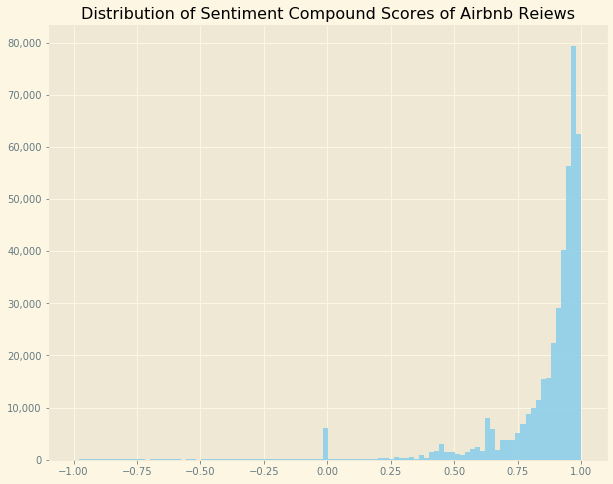

In [6]:
#Set plot
fig, ax = plt.subplots(figsize = (10,8))

#Plot hist of sentiment_compound scores
j = df.sentiment_compound.hist(ax = ax,bins = 100, color = 'skyblue', alpha = .85)

#Set plot aesthetics
j.set_title('Distribution of Sentiment Compound Scores of Airbnb Reiews')
ax.set_yticklabels(['{:,}'.format(int(y)) for y in ax.get_yticks()]);

## Positive, neutral, and negative review label counts

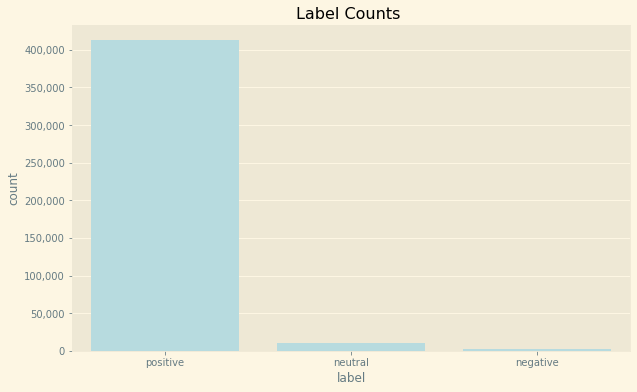

In [7]:
#Set plot
fig, ax = plt.subplots(figsize=(10,6))

#plot data
g =sns.countplot(x='label', data = df,order = ['positive', 'neutral', 'negative'], color='powderblue')

#Set plot aesthetics
g.set_title('Label Counts ')
g.set_yticklabels(['{:,}'.format(int(y)) for y in ax.get_yticks()]);

## Distribution of word counts for positive and negative reviews

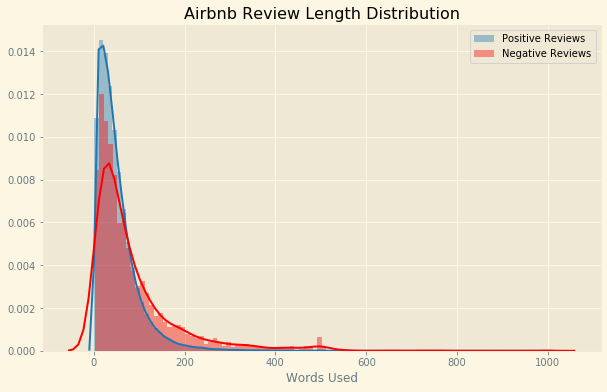

In [8]:
#Create pos/negative df's
pos_df = df[df.label == 'positive']
neg_df = df[df.label == 'negative']

#Create pos/neg corpora
pos_comments = pos_df['comments'].tolist()
neg_comments = neg_df['comments'].tolist()

#Set plot
fig, ax = plt.subplots(figsize=(10,6))

#Plot Histograms for word count
sns.distplot(pos_df.word_count, kde = True, bins = 100, color = 'tab:blue', ax=ax)
sns.distplot(neg_df.word_count, kde = True, bins = 100, color = 'r', ax=ax)

#Set plot aesthetics
ax.legend(labels = ['Positive Reviews', 'Negative Reviews', 'Neutral Reviews'], frameon = True);
ax.set_title('Airbnb Review Length Distribution')
ax.set_xlabel('Words Used');

## Word clouds and frequency counts of positive and negative reviews

In [9]:
#Import libraries 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

### Postive Reviews 

**WordCloud**

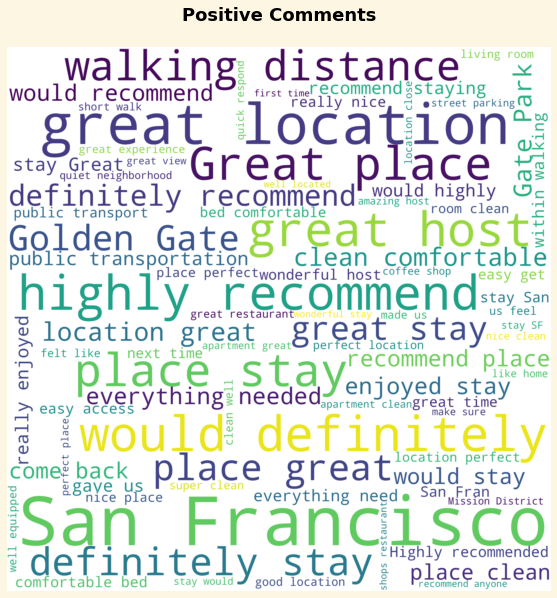

In [10]:
#Import stopwords
from nltk.corpus import stopwords, wordnet
stop_words = stopwords.words('english')

#Add additional stop words
stop_words.extend(['airbnb','website hidden by airbnb'])

#Create wordcloud for postive reviews
wordcloud = WordCloud(max_font_size=500, max_words=80, background_color="white", stopwords=stop_words,
                      width= 4000, height = 4000).generate(str(pos_comments))

#Plot data and set plot aesthetics
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title('Positive Comments\n', fontsize=18, fontweight='bold')
plt.show()

**Positive Word Frequency Distributions**

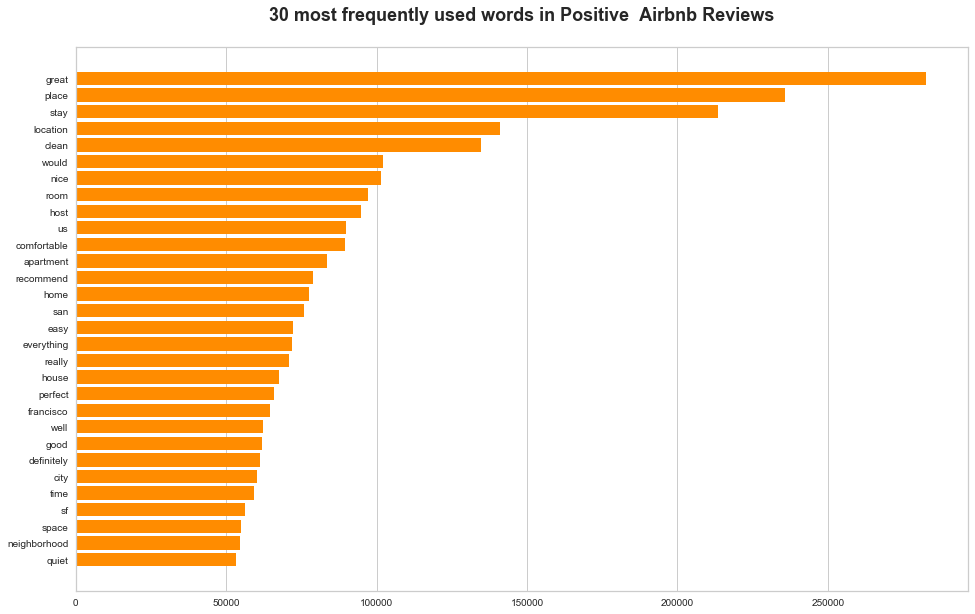

In [11]:
from sklearn.feature_extraction.text import CountVectorizer
from yellowbrick.text.freqdist import FreqDistVisualizer

#Vectorize comments and also remove stop words
cv = CountVectorizer(stop_words=stop_words)
positive_docs = cv.fit_transform(pos_comments)
features = cv.get_feature_names()

#Preparing the plot
plt.figure(figsize=(16,10))
plt.title('30 most frequently used words in Positive  Airbnb Reviews\n', fontsize = 18, fontweight='bold')

# instantiating and fitting the FreqDistVisualizer, plotting the top 30 most frequent terms
visualizer = FreqDistVisualizer(features=features, n=30, orient='h', color = 'darkorange')
visualizer.fit(positive_docs)
visualizer.poof;

### Negative Reviews

**WordCloud**

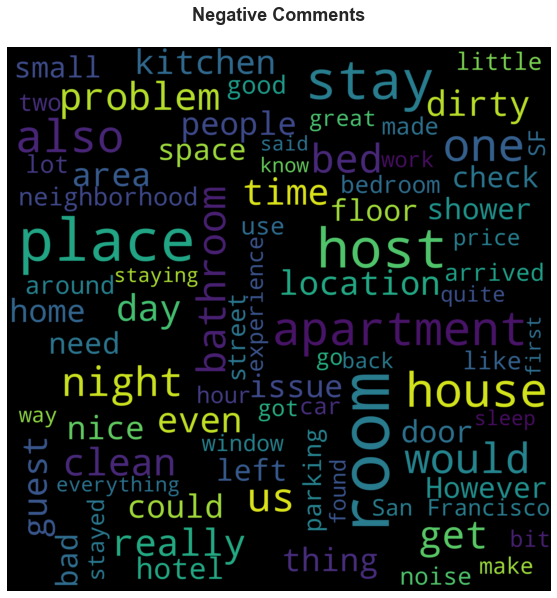

In [12]:
#Create wordcloud for postive reviews
wordcloud = WordCloud(max_font_size=500, max_words=80, background_color="black",stopwords=stop_words,
                      width= 4000, height = 4000).generate(str(neg_comments))

#Plot data and set plot aesthetics
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.title('Negative Comments\n', fontsize=18, fontweight='bold')
plt.show()

**Negative Word Frequency Distributions**

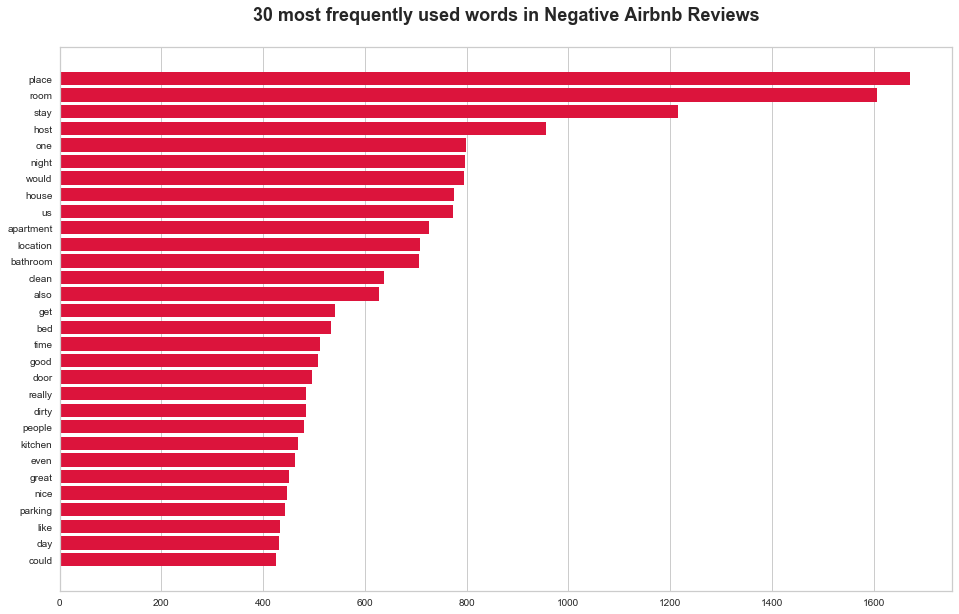

In [13]:
#Vectorize comments and also remove stop words
cv = CountVectorizer(stop_words=stop_words)
negative_docs = cv.fit_transform(neg_comments)
features = cv.get_feature_names()

#Preparing the plot
plt.figure(figsize=(16,10))
plt.title('30 most frequently used words in Negative Airbnb Reviews\n', fontsize = 18, fontweight='bold')

# instantiating and fitting the FreqDistVisualizer, plotting the top 30 most frequent terms
visualizer = FreqDistVisualizer(features=features, n=30, orient='h',color='crimson')
visualizer.fit(negative_docs)
visualizer.poof;

# Topic Modeling for Positive Reviews

Topic modeling will be performed seperately for positive and negative reviews due to the fact that a large majority of the reviews are positive reviews. Additionally, due to the sheer number of reviews, we will focus our topic analysis on the most positive and negative user experiecnes in the data set

## Import libraries

In [14]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Import spacy for lemmatization
from spacy.lang.en import English
import spacy
import en_core_web_lg
nlp = en_core_web_lg.load()

#Reg exp
import re

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  
import matplotlib.pyplot as plt

## Data Preparation

In [82]:
#How many really negative and positive reviews are there?
print("Number of reviews with a sentiment score < -.9: ",len(df[df.sentiment_compound < -.9]))
print("Number of reviews with a sentiment score > .9: ",len(df[df.sentiment_compound>.9]))

#Subset all negative reviews < -.9
neg_reviews = df[df.sentiment_compound < -.5]

#Subset 10% of all positive reviews > .9 
pos_reviews = df[df.sentiment_compound >.9][::10]

#Update pos/neg corpora
pos_comments = pos_reviews['comments'].tolist()
neg_comments = neg_reviews['comments'].tolist()

Number of reviews with a sentiment score < -.9:  315
Number of reviews with a sentiment score > .9:  266560


### Functions for data cleaning and tokenization

In [16]:
#Tokenize each sentence into a list of words and remove punctuation
def tokenizer(raw_reviews):
    for review in raw_reviews:
        yield(gensim.utils.simple_preprocess(review, deacc=True))
        
#Remove stopwords
def remove_stopwords(texts):
    texts = [texts.remove(text) if len(text) <3 else text for text in texts] #remove texts with len <3
    texts = [text for text in texts if text] #Remove None from texts
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

### Tokenize a comments

In [17]:
#Tokenize pos_comments and remove puncuation
pos_tokens = list(tokenizer(pos_comments))

#Check
print(pos_tokens[0])

['hello', 'josh', 'thank', 'you', 'very', 'much', 'for', 'everything', 'found', 'myself', 'very', 'comfortable', 'in', 'your', 'home', 'quiet', 'comfortable', 'and', 'very', 'complete', 'and', 'very', 'clean', 'which', 'value', 'highly', 'next', 'time', 'come', 'with', 'my', 'family', 'hope', 'it', 'possible']


**Creating Bigram and Trigram Models**

In [18]:
#Build bigram and trigram models
bigram = gensim.models.Phrases(pos_tokens,min_count=5, threshold=100)#Might need to increse with full data set
trigram = gensim.models.Phrases(bigram[pos_tokens], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [19]:
#Check
print(pos_tokens[2])

['when', 'left', 'phil', 'yesterday', 'morning', 'at', 'west', 'portal', 'we', 'hugged', 'this', 'is', 'my', 'second', 'time', 'staying', 'with', 'phil', 'only', 'this', 'time', 'had', 'the', 'garden', 'suite', 'which', 'believe', 'he', 'was', 'creating', 'last', 'year', 'think', 'we', 'have', 'become', 'friends', 'maybe', 'an', 'odd', 'combo', 'jewish', 'bubbi', 'from', 'brooklyn', 'going', 'to', 'be', 'this', 'year', 'and', 'he', 'asian', 'american', 'and', 'much', 'much', 'younger', 'but', 'think', 'we', 're', 'friends', 'phil', 'warm', 'and', 'open', 'the', 'space', 'he', 'makes', 'in', 'his', 'home', 'is', 'one', 'he', 'has', 'in', 'his', 'heart', 'his', 'heart', 'embraces', 'nature', 'and', 'the', 'inner', 'space', 'he', 'creates', 'reflects', 'his', 'love', 'of', 'being', 'in', 'natural', 'environment', 'it', 'uses', 'light', 'and', 'shadow', 'wood', 'tones', 'and', 'clean', 'lines', 'to', 'provide', 'open', 'space', 'place', 'in', 'which', 'to', 'pause', 'and', 'find', 'serenit

In [20]:
print(trigram_mod[bigram_mod[pos_tokens[2]]])

['when', 'left', 'phil', 'yesterday', 'morning', 'at', 'west_portal', 'we', 'hugged', 'this', 'is', 'my', 'second', 'time', 'staying', 'with', 'phil', 'only', 'this', 'time', 'had', 'the', 'garden', 'suite', 'which', 'believe', 'he', 'was', 'creating', 'last', 'year', 'think', 'we', 'have', 'become', 'friends', 'maybe', 'an', 'odd', 'combo', 'jewish', 'bubbi', 'from', 'brooklyn', 'going', 'to', 'be', 'this', 'year', 'and', 'he', 'asian', 'american', 'and', 'much', 'much', 'younger', 'but', 'think', 'we', 're', 'friends', 'phil', 'warm', 'and', 'open', 'the', 'space', 'he', 'makes', 'in', 'his', 'home', 'is', 'one', 'he', 'has', 'in', 'his', 'heart', 'his', 'heart', 'embraces', 'nature', 'and', 'the', 'inner', 'space', 'he', 'creates', 'reflects', 'his', 'love', 'of', 'being', 'in', 'natural', 'environment', 'it', 'uses', 'light', 'and', 'shadow', 'wood', 'tones', 'and', 'clean', 'lines', 'to', 'provide', 'open', 'space', 'place', 'in', 'which', 'to', 'pause', 'and', 'find', 'serenity',

Remove stopwords, create trigrams, and lemmatize

In [21]:
#Remove stopwords from pos_tokens
pos_tokens_clean = remove_stopwords(pos_tokens)

#check
print(pos_tokens_clean[2])

['left', 'phil', 'yesterday', 'morning', 'west', 'portal', 'hugged', 'second', 'time', 'staying', 'phil', 'time', 'garden', 'suite', 'believe', 'creating', 'last', 'year', 'think', 'become', 'friends', 'maybe', 'odd', 'combo', 'jewish', 'bubbi', 'brooklyn', 'going', 'year', 'asian', 'american', 'much', 'much', 'younger', 'think', 'friends', 'phil', 'warm', 'open', 'space', 'makes', 'home', 'one', 'heart', 'heart', 'embraces', 'nature', 'inner', 'space', 'creates', 'reflects', 'love', 'natural', 'environment', 'uses', 'light', 'shadow', 'wood', 'tones', 'clean', 'lines', 'provide', 'open', 'space', 'place', 'pause', 'find', 'serenity', 'think', 'meditative', 'moment', 'woods', 'sunshine', 'utilitarian', 'nothing', 'omitted', 'serve', 'better', 'describe', 'allotted', 'space', 'slept', 'well', 'memory', 'foam', 'mattress', 'totally', 'comfortable', 'provided', 'everything', 'heart', 'could', 'desire', 'space', 'actually', 'lifted', 'mood', 'made', 'joyous', 'website', 'hidden', 'example'

In [22]:
#Create functions to create bi/trigrams.
def bigrams(tokens):
    return[bigram_mod[token] for token in tokens]

def trigrams(tokens):
    return[trigram_mod[bigram_mod[token]] for token in tokens]

In [23]:
trigrams = trigrams(pos_tokens_clean)

In [24]:
#check
print(trigrams[0:2])

[['hello', 'josh', 'thank', 'much', 'everything', 'found', 'comfortable', 'home', 'quiet', 'comfortable', 'complete', 'clean', 'value', 'highly', 'next', 'time', 'come', 'family', 'hope', 'possible'], ['would', 'like', 'walk', 'city', 'place', 'minute', 'walk', 'handful', 'good', 'places', 'see', 'eat', 'italian', 'district', 'comprises', 'north_beach', 'area', 'best', 'food', 'wife', 'ever', 'used', 'apartment', 'home', 'base', 'day', 'great', 'place', 'within', 'nice', 'proximity', 'able', 'come', 'back', 'regroup', 'head', 'dinner', 'next', 'excursion', 'given', 'day', 'studio', 'amenities', 'perfect', 'us', 'problems', 'space', 'issues', 'otherwise', 'looking', 'live', 'like', 'local', 'san', 'francisco', 'probably', 'best', 'area', 'equally', 'spaced', 'fishermans_wharf', 'financial_district', 'union_square', 'lombards', 'st', 'many', 'points', 'interest', 'walking', 'hill', 'way', 'home', 'dinner', 'would', 'usually', 'stop', 'one', 'bodega', 'grab', 'bottle', 'wine', 'nightcap',

In [25]:
lemmatized_text = []
def lemmatization(texts, pos_tags = ['NOUN', 'ADJ', 'VERB', 'ADV']):
 #   lemmatized_text = []
    for item in texts:
        doc = nlp(" ".join(item))
        lemmatized_text.append([token.lemma_ for token in doc if token.pos_ in pos_tags])
    return lemmatized_text

In [26]:
# Initialize spacy 'en' model keeping only tagger component 
nlp = spacy.load('en_core_web_lg', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(list(trigrams),pos_tags = ['NOUN', 'ADJ', 'VERB', 'ADV'])

In [27]:
#check
print((data_lemmatized[2]))

['leave', 'yesterday', 'morning', 'hug', 'second', 'time', 'stay', 'believe', 'create', 'last', 'year', 'think', 'become', 'friend', 'maybe', 'odd', 'combo', 'jewish', 'go', 'year', 'much', 'much', 'young', 'think', 'friend', 'open', 'space', 'make', 'home', 'heart', 'heart', 'embrace', 'nature', 'inner', 'space', 'create', 'reflect', 'love', 'natural', 'environment', 'use', 'light', 'shadow', 'wood', 'tone', 'clean', 'line', 'provide', 'open', 'space', 'place', 'pause', 'find', 'serenity', 'think', 'meditative', 'moment', 'wood', 'sunshine', 'utilitarian', 'omit', 'serve', 'better', 'describe', 'allot', 'space', 'sleep', 'well', 'memory_foam_mattress', 'totally', 'comfortable', 'provide', 'heart', 'could', 'desire', 'space', 'actually', 'lift', 'mood', 'make', 'joyous', 'website_hidden', 'example', 'bathroom', 'tile', 'cover', 'wall', 'contour', 'light', 'shadow', 'create', 'sensation', 'wave', 'shower', 'curtain', 'bubble', 'water', 'floor', 'sand', 'color', 'base', 'sink', 'color', 

Append lematized pos words to pos_df

In [28]:
#Assign lemmatized comments to pos_reviews df
pos_reviews['comments_lemmatized'] = data_lemmatized

#Check
pos_reviews.head(1)

,comments,date,sentiment_compound,label,word_count,comments_pos_tag,comments_lemmatized
0,"Hello Josh Thank you very much for everything. I found myself very comfortable in your home. Quiet, comfortable and very complete and very clean, which I value highly. Next time I'd come with my family. I hope it's possible.",2013-12-01,0.9534,positive,39,"[('hello', 'NN'), ('josh', 'NN'), ('thank', 'VBD'), ('much', 'JJ'), ('everything', 'NN'), ('comfortable', 'JJ'), ('home', 'NN'), ('quiet', 'RBR'), ('comfortable', 'JJ'), ('complete', 'JJ'), ('clean', 'JJ'), ('highly', 'RB'), ('next', 'JJ'), ('time', 'NN'), ('come', 'VBN'), ('possible', 'JJ')]","[thank, much, find, comfortable, home, quiet, comfortable, complete, clean, value, highly, next, time, come, family, hope, possible]"


## Bag of Words

In [29]:
dictionary = corpora.Dictionary(documents=data_lemmatized)
print(len(dictionary))

#Filter pos_lemmatized. Remove tokens that apppear in <15 documents and in more than 50% of the documents
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(text) for text in data_lemmatized]


print('Number of unique words in dictionary for positive reviews:', len(dictionary))

#Preview Bag Of Words for our sample preprocessed document.
bow_doc_1 = bow_corpus[1]
for i in range(len(bow_doc_1)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_1[i][0], 
                                               dictionary[bow_doc_1[i][0]], bow_doc_1[i][1]))

10271
Number of unique words in dictionary for positive reviews: 2201
Word 1 ("come") appears 1 time.
Word 7 ("home") appears 2 time.
Word 10 ("next") appears 1 time.
Word 16 ("able") appears 1 time.
Word 17 ("amenity") appears 1 time.
Word 18 ("apartment") appears 2 time.
Word 19 ("area") appears 2 time.
Word 20 ("back") appears 1 time.
Word 21 ("base") appears 1 time.
Word 22 ("beat") appears 1 time.
Word 23 ("blue") appears 1 time.
Word 24 ("bottle") appears 1 time.
Word 25 ("city") appears 3 time.
Word 26 ("coit_tower") appears 1 time.
Word 27 ("cool") appears 1 time.
Word 28 ("day") appears 2 time.
Word 29 ("dinner") appears 2 time.
Word 30 ("district") appears 1 time.
Word 31 ("eat") appears 1 time.
Word 32 ("enough") appears 1 time.
Word 33 ("equally") appears 1 time.
Word 34 ("ever") appears 1 time.
Word 35 ("excursion") appears 1 time.
Word 36 ("fall") appears 1 time.
Word 37 ("feel") appears 1 time.
Word 38 ("financial_district") appears 1 time.
Word 39 ("food") appears 1 tim

TF-IDF

In [30]:
from gensim import models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

#check
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.08891953732722502),
 (1, 0.20466851962301957),
 (2, 0.22641770795396482),
 (3, 0.4456169960383482),
 (4, 0.24260422632405745),
 (5, 0.2228435336995377),
 (6, 0.17531692765187887),
 (7, 0.15086946471229892),
 (8, 0.30922901048817736),
 (9, 0.21423830207337963),
 (10, 0.241996064187727),
 (11, 0.4080216666427162),
 (12, 0.16640767053634428),
 (13, 0.16595658795314835),
 (14, 0.15160709843948253),
 (15, 0.30589007003652474)]


Optimal Number of topics based on optimal coherence score

In [31]:
def get_coherence_values(dictionary, corpus, texts, max_topics, start=2, step=3):
    """
    Compute the coherence score for different LDA models
    of different topic number
    ----------------------------------------------------
    PARAMETERS:
    - dictionary : Gensim dictionary
    - corpus : Gensim corpus
    - texts : List of input texts
    - limit : Max num of topics 
    """
    coherence_scores = []
    model_list = []
    for topics in range(start, max_topics, step):
        model = gensim.models.LdaMulticore(corpus = corpus, num_topics=topics,workers=3, id2word=dictionary, random_state=24)
        model_list.append(model)
        coherence_model = CoherenceModel(model = model, texts=texts, dictionary=dictionary)
        coherence_scores.append(coherence_model.get_coherence())
    return model_list, coherence_scores

In [32]:
models, scores = get_coherence_values(dictionary=dictionary, corpus=corpus_tfidf, 
                                                    texts=data_lemmatized, start=2, max_topics=20, step=2)


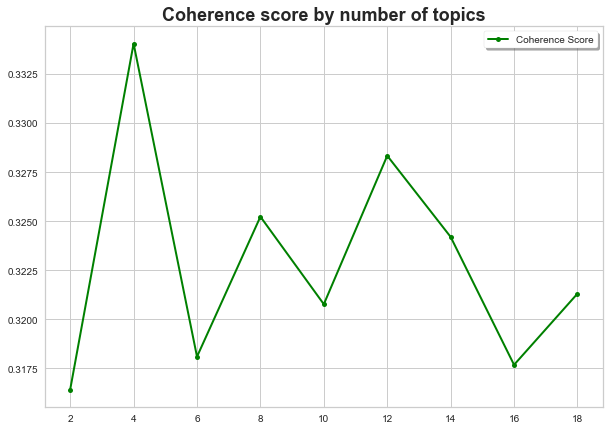

Coherence Score for LDA w/ 2 topics: 0.316
Coherence Score for LDA w/ 4 topics: 0.334
Coherence Score for LDA w/ 6 topics: 0.318
Coherence Score for LDA w/ 8 topics: 0.325
Coherence Score for LDA w/ 10 topics: 0.321
Coherence Score for LDA w/ 12 topics: 0.328
Coherence Score for LDA w/ 14 topics: 0.324
Coherence Score for LDA w/ 16 topics: 0.318
Coherence Score for LDA w/ 18 topics: 0.321


In [33]:
#Set range for xaxis
start=2; max_topics=20; step=2;
x= list(range(start, max_topics, step))

#Set plot size
plt.figure(figsize=(10,7))

#Plot coherence scores
plt.plot(x,scores, label = 'Coherence Score', color='green', marker='o', linestyle='-',
      linewidth=2, markersize=5, )

plt.title('Coherence score by number of topics', fontsize = 18, fontweight='bold')
plt.legend(frameon = True, shadow = True)
plt.show();

#Print coherence scores
for m, cv in zip(x, scores):
    print('Coherence Score for LDA w/', m,'topics:', round(cv,3))

Visualize Topics

Optimal model has 4 topics selected for our data

In [34]:
optimal_model = models[1]
model_topics = optimal_model.show_topics()

#Compute LDA model perplexity
print('Optimal LDA Model Perplexity: ', optimal_model.log_perplexity(corpus_tfidf))

#View topics
print('Optimal LDA Model Topics:')
display(optimal_model.print_topics())

Optimal LDA Model Perplexity:  -7.401050352817934
Optimal LDA Model Topics:


[(0,
  '0.008*"nice" + 0.008*"room" + 0.008*"place" + 0.008*"clean" + 0.007*"good" + 0.007*"apartment" + 0.007*"location" + 0.006*"really" + 0.006*"helpful" + 0.006*"comfortable"'),
 (1,
  '0.007*"place" + 0.006*"city" + 0.006*"make" + 0.005*"room" + 0.005*"location" + 0.005*"host" + 0.005*"would" + 0.005*"comfortable" + 0.005*"perfect" + 0.005*"easy"'),
 (2,
  '0.009*"wonderful" + 0.008*"host" + 0.008*"location" + 0.007*"apartment" + 0.007*"love" + 0.007*"place" + 0.007*"would" + 0.007*"recommend" + 0.006*"clean" + 0.006*"restaurant"'),
 (3,
  '0.009*"place" + 0.008*"nice" + 0.008*"clean" + 0.007*"location" + 0.007*"home" + 0.007*"easy" + 0.007*"comfortable" + 0.007*"super" + 0.007*"host" + 0.007*"recommend"')]

In [35]:
#Create plot
pyLDAvis.enable_notebook()

vis = pyLDAvis.gensim.prepare(optimal_model, corpus_tfidf, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.010640 -0.001561       1        1  26.589956
0     -0.013853 -0.024140       2        1  26.178778
3      0.023056  0.004480       3        1  24.246431
1     -0.019843  0.021221       4        1  22.984835, topic_info=              Term        Freq       Total Category  logprob  loglift
135      wonderful  598.000000  598.000000  Default  30.0000  30.0000
348      excellent  308.000000  308.000000  Default  29.0000  29.0000
399           view  402.000000  402.000000  Default  28.0000  28.0000
548     responsive  254.000000  254.000000  Default  27.0000  27.0000
139  accommodation  127.000000  127.000000  Default  26.0000  26.0000
..             ...         ...         ...      ...      ...      ...
311      beautiful  108.993782  533.948608   Topic4  -5.4388  -0.1187
187      recommend  111.263496  664.959412   Topic4  -5.4182  -0.3175
56            nice  112.747932  710.100952   Topic4  -5.4049  -0.3699
109           love  106.386208  578.777222   Topic4  -5.4630  -0.2235
42            good  106.891365  614.640259   Topic4  -5.4582  -0.2789

[373 rows x 6 columns], token_table=      Topic      Freq               Term
term                                    
16        1  0.233459               able
16        2  0.228029               able
16        3  0.206312               able
16        4  0.336615               able
1467      1  0.143001  absolute_pleasure
...     ...       ...                ...
81        4  0.193234              would
1563      1  0.110030           year_old
1563      2  0.660180           year_old
1563      3  0.146707           year_old
1563      4  0.110030           year_old

[937 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 4, 2])

Finding the dominant topic in each review

In [50]:
def topic_finder(ldamodel, corpus, text):
    """Returns dataframe contianing dominant topic 
    for each individual review for positive reviews"""
    pos_topics = pd.DataFrame()
    
    #Get main topic of each doc
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key = lambda x: (x[1]), reverse = True)
        
        #Get the dominant topic, percent contribution, and keywords for each document
        for j,(topic_num, prop_topic) in enumerate(row):
            if j == 0: #Dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                pos_topics = pos_topics.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    pos_topics.columns = ['Dominant_Topic', 'Percent_Contribution', 'Topic_Keywords']
    
    #Append original comments to pos_topics
    comments = pd.Series(text)
    pos_topics = pd.concat([pos_topics, comments], axis = 1)
    return pos_topics   

In [55]:
positive_topics = topic_finder(optimal_model,corpus_tfidf, pos_comments)

#Format positive_topics
positive_topics.columns = ['Dominant_Topic', 'Topic%_Contribution','Keywords', 'Reviews']

In [56]:
#Check
display(positive_topics.head())

,Dominant_Topic,Topic%_Contribution,Keywords,Reviews
0,2.0,0.8273,"wonderful, host, location, apartment, love, place, would, recommend, clean, restaurant","Hello Josh Thank you very much for everything. I found myself very comfortable in your home. Quiet, comfortable and very complete and very clean, which I value highly. Next time I'd come with my family. I hope it's possible."
1,1.0,0.9067,"place, city, make, room, location, host, would, comfortable, perfect, easy","If you would like to walk the city, this is the place to be. A 10-20 minute walk to more than a handful of good places too see, and eat. The Italian district which comprises most of the North Beach area, had some of the best food my wife and I have ever had. We used the apartment as a home base, were out most of the day. It was great to have this place within a nice proximity to be able to come back to, regroup, and then head out for dinner, or our next excursion for the given day. The studio amenities were perfect for us, no problems with space issues, or otherwise. If you are looking to ""live like a local"" in San Francisco, this is probably the best area to do it, very equally spaced from Fishermans wharf, Financial district, Union Square, Lombards St., and many other points of interest. Walking up the hill on the way home from dinner we would usually stop at one of the Bodega's, and grab a bottle of wine as a nightcap. Right before reaching the apartment, yo..."
2,1.0,0.9003,"place, city, make, room, location, host, would, comfortable, perfect, easy","When I left Phil yesterday morning at West Portal we hugged. This is my second time staying with Phil - only this time I had the Garden Suite, which I believe he was creating last year. I think we have become friends - maybe an odd combo - I'm a Jewish Bubbi from Brooklyn, going to be 79 this year, and he's Asian American and much, much younger. But, I think we're friends b/c Phil's warm and open. The space he makes in his home is one he has in his heart. His heart embraces nature - and the inner space he creates reflects his love of being in a natural environment. It uses light and shadow, wood tones, and clean lines to provide open space - a place in which to pause and find serenity. Think of a meditative moment in a woods. Sunshine. It's utilitarian, with nothing omitted if it will serve you better. I can't describe all this in the allotted space, but I not only slept well on the memory foam mattress, but was totally comfortable and was provided wit..."
3,2.0,0.5859,"wonderful, host, location, apartment, love, place, would, recommend, clean, restaurant","Ben's Victorian Apartment overlooking the Cole Valley neighborhood in San Francisco provides a truly fabulous spot for all ""airbnb"" travelers ! The accommodations are spectacular. Included with the apartment is a full kitchen to use as well as a washer and dryer for your convenience. I'm convinced there is no better location in San Francisco to stay then the apartment Ben offers. It is situated a block from the MUNI mass transit trains (thereby making the need for a car optional) among a darling ""family friendly"" neighborhood. There's ice cream to be savored and restaurants to be enjoyed. Local independent shops abound which will satisfy your every wish. For you ""Baby Boomers"" it's also important to note that Haight Ashbury lies just a few blocks away as well. Ben and his family were so hospitable they even kept our bags at their place after check out so we could partake of another full day enjoying all of the sights and sounds that the ""City by the Bay"" has to off..."
4,3.0,0.8417,"place, nice, clean, location, home, easy, comfortable, super, host, recommend","Spotlessly clean, brand new private one bedroom apartment with parking and nice kitchen. Safe and secure location, we felt very comfortable here. The hosts were attentive and the overall experience was trouble free. Would highly recommend this location."


In [52]:
temp.head()

,Dominant_Topic,Percent_Contribution,Topic_Keywords,0
0,2.0,0.8272,"wonderful, host, location, apartment, love, place, would, recommend, clean, restaurant","Hello Josh Thank you very much for everything. I found myself very comfortable in your home. Quiet, comfortable and very complete and very clean, which I value highly. Next time I'd come with my family. I hope it's possible."
1,1.0,0.9067,"place, city, make, room, location, host, would, comfortable, perfect, easy","If you would like to walk the city, this is the place to be. A 10-20 minute walk to more than a handful of good places too see, and eat. The Italian district which comprises most of the North Beach area, had some of the best food my wife and I have ever had. We used the apartment as a home base, were out most of the day. It was great to have this place within a nice proximity to be able to come back to, regroup, and then head out for dinner, or our next excursion for the given day. The studio amenities were perfect for us, no problems with space issues, or otherwise. If you are looking to ""live like a local"" in San Francisco, this is probably the best area to do it, very equally spaced from Fishermans wharf, Financial district, Union Square, Lombards St., and many other points of interest. Walking up the hill on the way home from dinner we would usually stop at one of the Bodega's, and grab a bottle of wine as a nightcap. Right before reaching the apartment, yo..."
2,1.0,0.9004,"place, city, make, room, location, host, would, comfortable, perfect, easy","When I left Phil yesterday morning at West Portal we hugged. This is my second time staying with Phil - only this time I had the Garden Suite, which I believe he was creating last year. I think we have become friends - maybe an odd combo - I'm a Jewish Bubbi from Brooklyn, going to be 79 this year, and he's Asian American and much, much younger. But, I think we're friends b/c Phil's warm and open. The space he makes in his home is one he has in his heart. His heart embraces nature - and the inner space he creates reflects his love of being in a natural environment. It uses light and shadow, wood tones, and clean lines to provide open space - a place in which to pause and find serenity. Think of a meditative moment in a woods. Sunshine. It's utilitarian, with nothing omitted if it will serve you better. I can't describe all this in the allotted space, but I not only slept well on the memory foam mattress, but was totally comfortable and was provided wit..."
3,3.0,0.5143,"place, nice, clean, location, home, easy, comfortable, super, host, recommend","Ben's Victorian Apartment overlooking the Cole Valley neighborhood in San Francisco provides a truly fabulous spot for all ""airbnb"" travelers ! The accommodations are spectacular. Included with the apartment is a full kitchen to use as well as a washer and dryer for your convenience. I'm convinced there is no better location in San Francisco to stay then the apartment Ben offers. It is situated a block from the MUNI mass transit trains (thereby making the need for a car optional) among a darling ""family friendly"" neighborhood. There's ice cream to be savored and restaurants to be enjoyed. Local independent shops abound which will satisfy your every wish. For you ""Baby Boomers"" it's also important to note that Haight Ashbury lies just a few blocks away as well. Ben and his family were so hospitable they even kept our bags at their place after check out so we could partake of another full day enjoying all of the sights and sounds that the ""City by the Bay"" has to off..."
4,3.0,0.8418,"place, nice, clean, location, home, easy, comfortable, super, host, recommend","Spotlessly clean, brand new private one bedroom apartment with parking and nice kitchen. Safe and secure location, we felt very comfortable here. The hosts were attentive and the overall experience was trouble free. Would highly recommend this location."


Topic Distribution across all documents

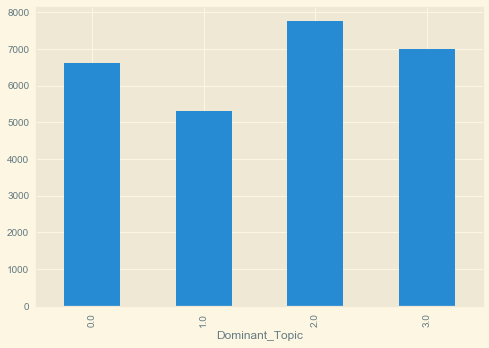

In [78]:
positive_topics.groupby('Dominant_Topic')['Dominant_Topic'].count().plot(kind = 'bar')

Find most representative document for each positive topic

In [74]:
top_docs = positive_topics.groupby('Dominant_Topic')['Topic%_Contribution'].nlargest(5).reset_index()

rows = list(top_docs['level_1'])
positive_topics.iloc[(rows)]

,Dominant_Topic,Topic%_Contribution,Keywords,Reviews
67,0.0,0.9248,"nice, room, place, clean, good, apartment, location, really, helpful, comfortable","1. The room is quite spacious and cozy. You have a big bed, a desk, and more than enough space for your stuff. Two bathrooms and a kitchen with various appliances are literally right out the door. So convenient. 2. The family is lovely. Leslie, the wife, despite being tired from job and housework, was so kind and helpful. She even let me stay in the room a couple of hours longer even after I checked out. Gio, her husband, gave me a warm welcome on the first day. Leslie's mother, who is mostly in charge of housework and taking care of children, was really nice as well, despite language barrier. Wilson, Leslie's brother, is a really cool guy and helped me with finding a location. Two children are adorable, especially the older one Kaden, who likes to brag about how fast he can run. It can be a little noisy during the day but the couple does a little good job keeping it quiet at night. 3. Amazing location. Having stayed near Powell station the last time, I felt a little intimidated by the homeless even during the day. However, this area was so quiet and peaceful. When I came back at around 8 or 9 pm, I didn't even spot a human figure from the bart station to the house. It's about 5-minute walk from Bart station, and 2-minute walk to muni bus stop, where you can take 14 or 14r bus, which goes through the Mission street to Powell Station. The Rapid bus takes you to downtown in less than 30 minutes. The last time I was here, I felt a little uncomfortable surrounded by so many chinese and mexican people, but taking the same bus almost every day, I learned to adapt and started to enjoy the bus ride. The bus runs all night long, and is always packed with people, which makes it safer than muni metro or bart. 4. I got to talk to a French couple and a Costa Rican couple who were staying in the other rooms. I guess that is one of the advantages of staying in this kind of accommodations: meeting people from the other side of the globe and getting to know them. Special thanks to the Costa Rican lady who generously shared her amazing coffee with me. Overall, the place was quite satisfying, and I would love to stay here again if I go back to the city."
1766,0.0,0.9232,"nice, room, place, clean, good, apartment, location, really, helpful, comfortable","At first I wasn't sure what to make of this place, but in the end I liked it. For some context, we are first time Air BnB users. We've previously booked several vacation cabin rentals through those other home rental sites, but never an in city apartment stay. First let me say this is a real apartment, let out by real people, who have a genuine concern about making the experience positive. We also really liked this location. There are dozens of shops, nice restaurants and markets within about an 8 minute walk of the unit. We've recently stayed at nearby hotels off Market Street, but this location is much nicer, cleaner, and friendlier. One thing to know about the unit: its on the second floor, 20 steps up a steep, narrow stairway. Beware of heavy luggage. Also, the bed is very comfortable. The unit is as described, a simple and authentic Hayes Valley apartment. It's completely furnished and supplied for your essential needs. The kitchenette has all that's needed for cooking meals and saving on your S.F. re$taurant budget. The bathroom is clean and fully functional, but rather small. No room for a Winnebago make-up case. It took me a few days to appreciate the simplicity this home. There are no high end touches. No Egyptian cotton sheets or fluffy Ritz quality pillows and towels. No fancy espresso machines or appliances. I'm guessing the whole place was furnished at antique stores and thrift shops, from the kitchen table down to the soup ladle. But it all matches perfectly. Nothing is out of place or out of character. The place could be used as a pe

# Negative Reviews